# **Experiment: Phase diagrams**

This notebook reproduces the results of the numerical experiments in

> P. Rademacher and C. A. Sing Long, "*Lift and unmask: Sparse models by lifting the atomic norm*." February 10, 2025.

You can use the following code to cite our work.
```bibtex
@misc{rademacher_lift_2025, 
  title   = {Lift and unmask: Sparse models by lifting the atomic norm},  
  author  = {Rademacher, Pablo and Sing Long, Carlos A.}, 
  date    = {2025-02-10}
}
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

from os.path import exists

if "../.." not in sys.path:
    sys.path.insert(0, "../..")

def savefig(fname, d, ns):
  plt.savefig(f'FIG/E01_{fname:s}_D{d:04d}_NS{ns:03d}.png', bbox_inches='tight', dpi=300)
  plt.savefig(f'FIG/E01_{fname:s}_D{d:04d}_NS{ns:03d}.eps', bbox_inches='tight')

In [2]:
# generate & save data
SAVE_DATA = True
# load data if exists
LOAD_DATA = True

## Contents

1. [The phase diagram for $\ell_1$-minimizaion](#the-phase-diagram-for--minimization)
2. [The atomic set](#the-atomic-set)
3. [Atomic signal model](#atomic-signal-model)

## The phase diagram for $\ell_1$-minimization

We work in dimension $d = 256$.

In [3]:
d = 256

$\ell_1$-norm recovery in the positive orthant is equivalent to atomic norm recovery when the atomic set $\mathcal{A}$ consists of the elements of the canonical basis. 

In [4]:
A = np.eye(d)

The signal model in this case is as follows. For a given sparsity parameter $\rho$ we draw a support $S$ of size $[\rho d]$ and a vector $\boldsymbol{x}_0$ with support $S$ and non-zero entries independently drawn from a $\mathsf{Exp}(1)$ distribution.

In [5]:
# save array for speed
smask = np.zeros((d,), dtype=float)
index = np.linspace(0, d-1, d).astype('int')
# draw a random signal
def draw_signal(rho):
  # size of support
  s = int(np.round(rho * d))
  # boundary cases
  if s == 0:
    s = 1
  if s == d:
    s = d - 1
  sindex = np.random.choice(index, s, replace=False).astype('int')
  # mask
  smask[:] = 0.0
  smask[sindex] = 1.0
  # coefficients
  xo = smask * np.random.exponential(1.0, size=(d,))
  # return
  return xo, xo

We choose the values for the sparsity parameter $\rho$ and the sampling parameter $\delta$. For each combination of $(\rho,\delta)$ we draw $20$ signals and $m\times d$ Gaussian matrices $\boldsymbol{\Phi}$ with $m = [\delta d]$ and
$$
  \Phi_{i,j} \stackrel{\text{iid}}{\sim} N(0, 1/\sqrt{m})
$$
and solve
$$
  \text{minimize}_{\boldsymbol{x}\in \mathbb{R}^d}\quad\|\boldsymbol{x}\|_1\quad\text{subject to}\quad \boldsymbol{\Phi}\boldsymbol{x} = \boldsymbol{\Phi}\boldsymbol{x}_0.
$$

In [6]:
# number of sampling fractions
num_m = 10
# number of sparsity parameters
num_s = 10
# number of experiments
num_e = 20
# values
mfvals = np.linspace(0, 1, num_m)
sfvals = np.linspace(0, 1, num_s)

In [7]:
VERBOSE = True

In [8]:
def recovery_experiment(draw_signal, reconstruct):
  # reconstruction error
  err = np.zeros((num_m, num_s, num_e), dtype=float)
  # underlying signal norm
  xo_nrm = np.zeros((num_m, num_s, num_e), dtype=float)
  # underlying coefficient norm
  co_nrm = np.zeros((num_m, num_s, num_e), dtype=float)
  # reconstructed coefficient norm
  c_nrm = np.zeros((num_m, num_s, num_e), dtype=float)
  # experiment
  for I, delta in enumerate(mfvals):
    m = int(np.round(delta * A.shape[0]))
    if m == 0:
      m = 1
    if m == A.shape[0]:
      m = A.shape[0] - 1
    for J, rho in enumerate(sfvals):
      s = int(np.round(rho * A.shape[1]))
      if s == 0:
        s = 1
      if s == A.shape[1]:
        s = s - 1
      if VERBOSE:
        print(f'[{1 + I * num_m + J:4d} of {num_m * num_s:4d} | |supp(c)|: {s:4d} ({rho:.3f}) | m: {m:4d} ({delta:.3f})]')
      for K in range(num_e):
        # signal
        xo, co = draw_signal(rho)
        # Gaussian matrix
        T = np.random.randn(m, d)
        # normalize columns
        T = T / np.linalg.norm(T, axis=0)
        # measurements
        yo = T @ xo
        # reconstruction coefficients
        cx = reconstruct(T, yo)
        # reconstruction
        x = A @ cx
        # error
        err[I, J, K] = np.linalg.norm(x - xo)
        # norms
        xo_nrm[I, J, K] = np.linalg.norm(xo)
        co_nrm[I, J, K] = np.linalg.norm(co, ord=1)
        c_nrm[I, J, K] = np.linalg.norm(cx, ord=1)
  return err, xo_nrm, co_nrm, c_nrm

We use the specific implementation of $\ell_1$-norm minimization using atomic norm minimization with the atomic set
$$
  \mathcal{A} = \{\boldsymbol{e}_1,\ldots, \boldsymbol{e}_d\}.
$$

In [9]:
from liftedAtomicNormRecovery.solver.cvxpy import AtomicNormRecovery

atomicRecovery = AtomicNormRecovery()

We save the data to reproduce the plots.

In [10]:
fname = f'DAT/E01_L1RECOVERY_D{d:04d}_NS{num_e:04}.npz'

if LOAD_DATA and exists(fname):
  err = np.load(fname)['err']
  xo_nrm = np.load(fname)['xo_nrm']
else:
  err, xo_nrm, co_nrm, c_nrm = recovery_experiment(draw_signal, lambda T, y : atomicRecovery.solve(A, T, y))

  if SAVE_DATA:
    np.savez(fname, err=err, xo_nrm=xo_nrm, co_nrm=co_nrm, c_nrm=c_nrm)

In [11]:
ticks = [ 0, (num_m - 1) / 4, (num_m - 1) / 2, 3 * (num_m - 1) / 4, num_m - 1]
tick_labels = [ '0.00', '0.25', '0.50', '0.75', '1.00' ]

def plot_results(err, xo_nrm, eps = 1E-2):
  err_avg = np.mean(err, axis=2)
  pd = np.mean(np.where(err <= eps * xo_nrm, 1.0, 0.0), axis=2)
  
  plt.figure(figsize=(14, 6), layout='constrained')
  plt.subplot(1, 2, 1)
  plt.imshow(err_avg, origin='lower', cmap='gray')
  plt.xlim([ 0, num_s - 1 ])
  plt.ylim([ 0, num_m - 1 ])
  plt.xticks(ticks, labels=tick_labels)
  plt.yticks(ticks, labels=tick_labels)
  plt.xlabel('$\\rho$', fontsize=12)
  plt.ylabel('$\\delta$', fontsize=12)
  plt.colorbar(shrink=0.75)
  plt.subplot(1, 2, 2)
  plt.imshow(pd, cmap='gray', origin='lower')
  plt.xticks(ticks, labels=tick_labels)
  plt.yticks(ticks, labels=tick_labels)
  plt.xlim([ 0, num_s - 1 ])
  plt.ylim([ 0, num_m - 1 ])
  plt.xlabel('$\\rho$', fontsize=12)
  plt.ylabel('$\\delta$', fontsize=12)
  plt.colorbar(shrink=0.75)
  plt.show()

We plot both the average (absolute) reconstruction error and the phase diagram.

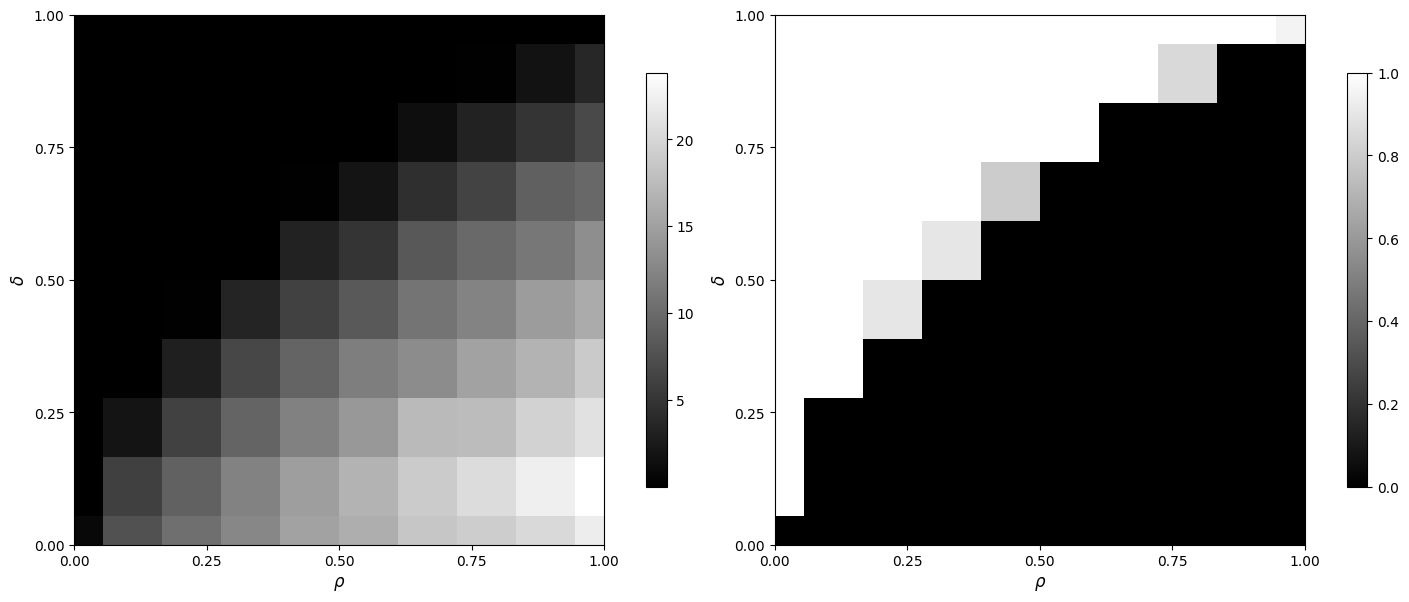

In [12]:
plot_results(err, xo_nrm)

In [13]:
# figure for paper ------------------------------------------------------------------------------------------
pd = np.mean(np.where(err <= 1E-2 * xo_nrm, 1.0, 0.0), axis=2)

plt.figure(figsize=(6, 6), layout='constrained')
plt.imshow(pd, origin='lower', cmap='gray')
plt.xlim([ 0, num_s - 1 ])
plt.ylim([ 0, num_m - 1 ])
plt.xticks(ticks, labels=tick_labels, fontsize=14)
plt.yticks(ticks, labels=tick_labels, fontsize=14)
plt.xlabel('$\\rho$', fontsize=16)
plt.ylabel('$\\delta$', fontsize=16)
cb = plt.colorbar(shrink=0.5, ticks=[ 0.0, 0.25, 0.50, 0.75, 1.00 ])
cb.ax.tick_params(labelsize=14)

savefig('PD_L1', d, num_e)

plt.close()

## The atomic set

We construct an atomic set $\mathcal{A}$ in $\mathbb{R}^d$ with masked atoms as follows. First, let $\mathcal{A}_e = \{\boldsymbol{e}_1,\ldots, \boldsymbol{e}_d\}$.

In [14]:
# number of exposed atoms
ne = d
# exposed atoms
Ae = np.eye(d)

Let $\rho_1,\ldots, \rho_\ell\in (0, 1]$ be sparsity parameters. We will generate sets $\mathcal{A}'_1,\ldots, \mathcal{A}'_{\ell}$ of atoms with $d$ elements each for a total of $n = (\ell + 1) d$ atoms of which $\ell d$ are masked atoms.

In [15]:
# support fraction
rho_masked = [ 0.1, 0.2 ]
# number of layers
num_layers = len(rho_masked)
# number of masked atoms
nm = num_layers * d

We generate the sets $\mathcal{A}'_1,\ldots, \mathcal{A}'_{\ell}$ as follows.

For every $k$ we generate $d$ random vectors $\boldsymbol{z}_1,\ldots,\boldsymbol{z}_{d}$ with support of size $s_k = [\rho_k d]$ selected at random. The non-zero entries are drawn independently from an $\mathsf{Exp}(1)$ distribution. The elements of $\mathcal{A}'_k$ are then
$$
    \boldsymbol{a}_i = \frac{1}{\sqrt{s_k}}\left(1 - \frac{k}{\ell + 1}\right)\frac{1}{\|\boldsymbol{z}_i\|_2}\boldsymbol{z}_i\quad\text{for}\quad i \in\{1,\ldots, d\}.
$$
We save the atoms to reproduce the results.

In [16]:
fname = f'DAT/E01_MASKED_ATOMS_D{d:04d}.npz'

if LOAD_DATA and exists(fname):
  Ah = np.load(fname)['Ah']
else:
  # full support
  xindex = np.linspace(0, d-1, d).astype('int')
  # generate masked atoms
  Ah = []
  for I, rho in enumerate(rho_masked):
    # support size
    ns = int(rho * d)
    for J in range(d):
      # choose support
      asupp = np.random.choice(xindex, ns, replace=False)
      # generate values
      a = np.zeros((d,), dtype=float)
      a[asupp] = np.random.exponential(1.0, asupp.size)
      # normalize atom
      p = 2
      sa = (1 - (I + 1) / (num_layers + 1))
      a = sa * (a / np.linalg.norm(a, ord=p)) / asupp.size ** (1 - 1/p)
      # append
      Ah.append(a)
  Ah = np.array(Ah, dtype=float).T

  if SAVE_DATA:
    np.savez(fname, Ah=Ah)

We check the norm of each atom and the sparsity pattern of each atom.

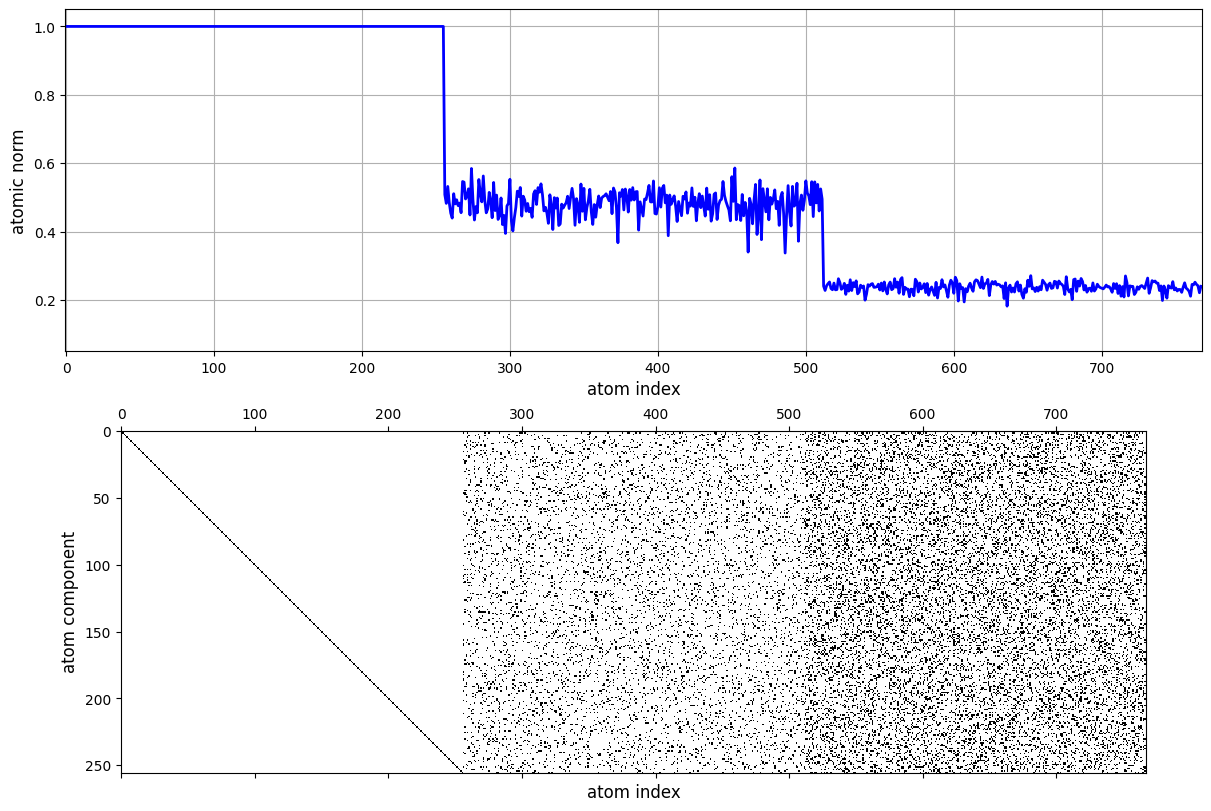

In [17]:
# atomic set
A = np.hstack([ Ae, Ah ])
# total number of atoms
n = A.shape[1]
# atomic norm
anrm_A = np.linalg.norm(A, ord=1, axis=0)

plt.figure(figsize=(12, 8), layout='constrained')
plt.subplot(2, 1, 1)
plt.plot(range(n), anrm_A, color='b', linewidth=2, linestyle='-')
plt.xlim([ -0.5, n - 0.5 ])
plt.ylim([ 0.05, 1.05 ])
plt.xlabel('atom index', fontsize=12)
plt.ylabel('atomic norm', fontsize=12)
plt.grid('both')
plt.subplot(2, 1, 2)
plt.spy(A)
plt.xlabel('atom index', fontsize=12)
plt.ylabel('atom component', fontsize=12)
plt.show()

## Atomic signal model

We consider the following atomic signal model. Fix $0 \leq \nu_- < \nu_+ \leq 1$ and define
$$
    I(\nu_-,\nu_+) = \set{i\in\set{1,\ldots, n}:\,\, \nu_-\leq \rho_{\mathcal{A}}(\boldsymbol{a}_i) \leq \nu_+},
$$
where $\rho_{\mathcal{A}}$ is the atomic norm, and let $n^\ast = |I(\nu_-, \nu_+)|$. For a given sparsity parameter $\rho \in (0, 1]$, we select a random subset $S\subset I(\nu_-,\nu_+)$ with $[\rho n^\ast]$ elements. We then draw a vector $\boldsymbol{c}_0$ with support $S$ such that its non-zero entries are drawn independently from a $\mathsf{Exp}(1)$ distribution. We then let $\boldsymbol{x}_0 = \boldsymbol{A}\boldsymbol{c}_0$. This leads to a sample $(\boldsymbol{x}_0, \boldsymbol{c}_0)$.

In [18]:
# masking level
anrm_bounds = [ 0.40, 0.60 ]
# indices of masked atoms
index = np.where(np.logical_and(anrm_bounds[0] <= anrm_A, anrm_A <= anrm_bounds[1]))[0]

print('Number of atoms selected by the atomic signal model: ', index.size)

Number of atoms selected by the atomic signal model:  248


We can show the atoms that can be selected by this model.

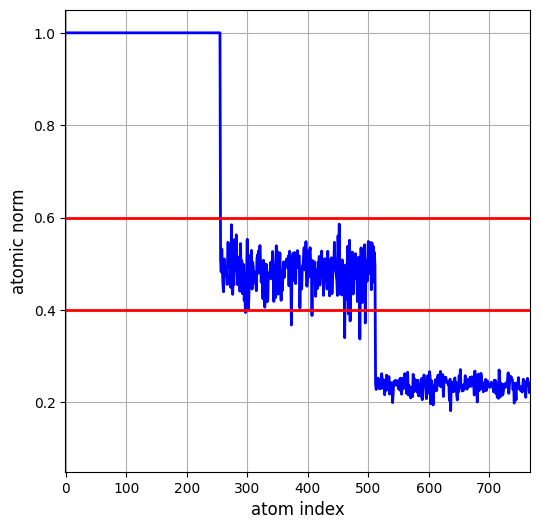

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(range(n), anrm_A, color='b', linewidth=2, linestyle='-')
plt.plot(range(n), anrm_bounds[0] * np.ones((n,)), color='r', linewidth=2, linestyle='-')
plt.plot(range(n), anrm_bounds[1] * np.ones((n,)), color='r', linewidth=2, linestyle='-')
plt.xlim([ -0.5, n - 0.5 ])
plt.ylim([ 0.05, 1.05 ])
plt.xlabel('atom index', fontsize=12)
plt.ylabel('atomic norm', fontsize=12)
plt.grid('both')
plt.show()

In [20]:
# figure for paper ------------------------------------------------------------------------------------------

plt.figure(figsize=(6, 6), layout='constrained')
plt.plot(range(1, n+1), anrm_A, color='b', linewidth=2, linestyle='-')
plt.plot(range(1, n+1), anrm_bounds[0] * np.ones((n,)), color='r', linewidth=2, linestyle='-')
plt.plot(range(1, n+1), anrm_bounds[1] * np.ones((n,)), color='r', linewidth=2, linestyle='-')
plt.xlim([ 0.5, n + 0.5 ])
plt.ylim([ 0.05, 1.05 ])
plt.xlabel('atom index', fontsize=16)
plt.ylabel('atomic norm', fontsize=16)
plt.xticks([ 1, n //4, n // 2, 3 * n // 4, n ], fontsize=14)
plt.yticks([ 0.0, 0.25, 0.50, 0.75, 1.00 ], fontsize=14)
plt.grid('both')

savefig('ATOMIC_NORMS', d, num_e)

plt.close()

In [21]:
# save array for speed
smask = np.zeros((n,), dtype=float)
# draw a random signal
def draw_signal(rho):
  # size of support
  ns = int(np.round(rho * index.size))
  # boundary case
  if ns == 0:
    ns = 1
  if ns == index.size:
    ns = index.size - 1
  if ns == 1:
    sindex = np.random.randint(0, ns)
  else:
    sindex = np.random.choice(index, ns, replace=False).astype('int')
  # mask
  smask[:] = 0.0
  smask[sindex] = 1.0
  # coefficients
  co = smask * np.random.exponential(1.0, size=(n,))
  # return
  return A @ co, co

## Phase diagrams

For each of the methods below we choose the same values for the sparsity parameter $\rho$ and the sampling parameter $\delta$ as before. For each combination of $(\rho,\delta)$ we draw $20$ pairs $(\boldsymbol{x}_0,\boldsymbol{c}_0)$ and matrices $\boldsymbol{\Phi}$ to reconstruct $\boldsymbol{x}_0$ from $\boldsymbol{y}_0 = \boldsymbol{\Phi}\boldsymbol{x}_0$.

### Atomic norm

By construction, the standard atomic norm recovery problem is equivalent to $\ell_1$-norm recovery.

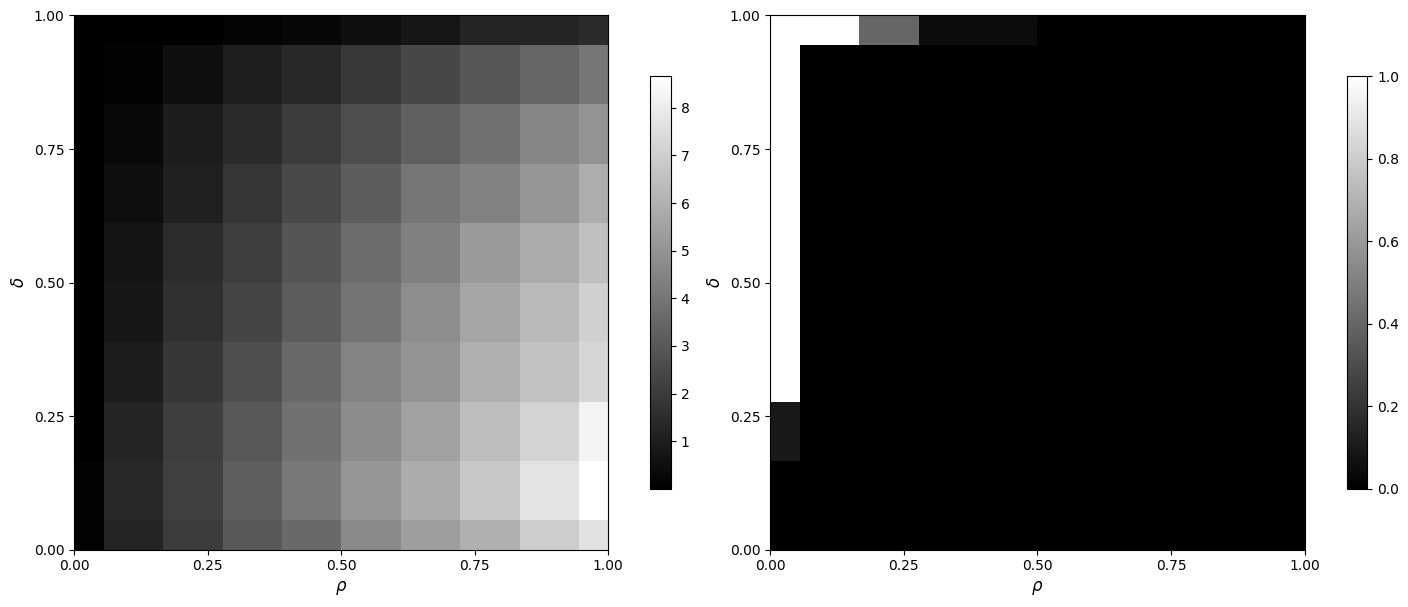

In [22]:
fname = f'DAT/E01_ATOMIC_NORM_D{d:04d}_NS{num_e:04}.npz'

if LOAD_DATA and exists(fname):
  err = np.load(fname)['err']
  xo_nrm = np.load(fname)['xo_nrm']
else:
  err, xo_nrm, co_nrm, c_nrm = recovery_experiment(draw_signal, lambda T, y : atomicRecovery.solve(A, T, y))

  if SAVE_DATA:
    np.savez(fname, err=err, xo_nrm=xo_nrm, co_nrm=co_nrm, c_nrm=c_nrm)

plot_results(err, xo_nrm)

In [23]:
# figure for paper ------------------------------------------------------------------------------------------

pd = np.mean(np.where(err <= 1E-2 * xo_nrm, 1.0, 0.0), axis=2)

plt.figure(figsize=(6, 6), layout='constrained')
plt.imshow(pd, origin='lower', vmin=0, vmax=1, cmap='gray')
plt.xlim([ 0, num_s - 1 ])
plt.ylim([ 0, num_m - 1 ])
plt.xticks(ticks, labels=tick_labels, fontsize=14)
plt.yticks(ticks, labels=tick_labels, fontsize=14)
plt.xlabel('$\\rho$', fontsize=16)
plt.ylabel('$\\delta$', fontsize=16)
cb = plt.colorbar(shrink=0.5, ticks=[ 0.0, 0.25, 0.50, 0.75, 1.00 ])
cb.ax.tick_params(labelsize=14)

savefig('PD_ATOMIC', d, num_e)

plt.close()

### Atomic norm with normalized atoms

The atomic norm with normalized atoms corresponds to atomic norm recovery using the atomic set $\bar{\mathcal{A}}$ of atoms normalized by their $\ell_2$-norm. If we let $\bar{\boldsymbol{A}}$ be the corresponding matrix, then we solve
$$
  \text{minimize}_{\boldsymbol{c}\in \mathbb{R}^n_+}\quad \boldsymbol{1}_n^{\top}\boldsymbol{c}\quad\text{subject to}\quad \boldsymbol{\Phi}\bar{\boldsymbol{A}}\boldsymbol{c} = \boldsymbol{y}_0.
$$
If $\boldsymbol{c}^\star$ is an optimal solution to the above, then $\boldsymbol{x}^{\star} = \bar{\boldsymbol{A}}\boldsymbol{c}^{\star}$ is the recovered signal.

In [24]:
An = A / np.linalg.norm(A, ord=2, axis=0)

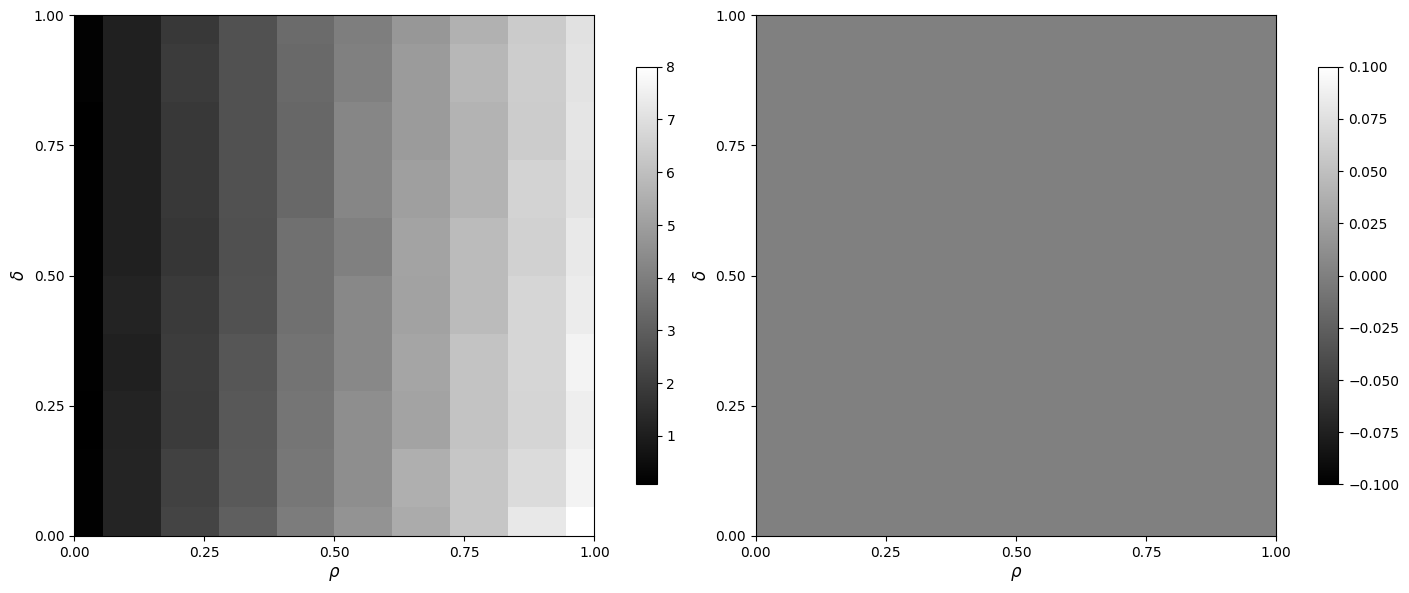

In [25]:
fname = f'DAT/E01_ATOMIC_NORM_NORMALIZED_D{d:04d}_NS{num_e:04}.npz'

if LOAD_DATA and exists(fname):
  err = np.load(fname)['err']
  xo_nrm = np.load(fname)['xo_nrm']
else:
  err, xo_nrm, co_nrm, c_nrm = recovery_experiment(draw_signal, lambda T, y : atomicRecovery.solve(An, T, y))

  if SAVE_DATA:
    np.savez(fname, err=err, xo_nrm=xo_nrm, co_nrm=co_nrm, c_nrm=c_nrm)

plot_results(err, xo_nrm)

In [26]:
# figure for paper ------------------------------------------------------------------------------------------

pd = np.mean(np.where(err <= 1E-2 * xo_nrm, 1.0, 0.0), axis=2)

plt.figure(figsize=(6, 6), layout='constrained')
plt.imshow(pd, origin='lower', vmin=0, vmax=1, cmap='gray')
plt.xlim([ 0, num_s - 1 ])
plt.ylim([ 0, num_m - 1 ])
plt.xticks(ticks, labels=tick_labels, fontsize=14)
plt.yticks(ticks, labels=tick_labels, fontsize=14)
plt.xlabel('$\\rho$', fontsize=16)
plt.ylabel('$\\delta$', fontsize=16)
cb = plt.colorbar(shrink=0.5, ticks=[ 0.0, 0.25, 0.50, 0.75, 1.00 ])
cb.ax.tick_params(labelsize=14)

savefig('PD_NORMALIZED', d, num_e)

plt.close()

### Lifted atomic norm with lifted variable

To construct the lifted atomic norm we first construct the lifted coordinates and the vector $\boldsymbol{\lambda}$ of lifted coordinates.

In [27]:
# lifting coordinate
lam_A = np.sqrt(1 - anrm_A ** 2)
# ranges 
lam_bounds = np.sqrt(1 - np.array(anrm_bounds) ** 2)

print(f'Bounds on lifted coordinates: [{lam_bounds[1]:.3f}, {lam_bounds[0]:.3f}]')

Bounds on lifted coordinates: [0.800, 0.917]


For this choice of lifting coordinate we can compare the samples for $(\boldsymbol{1}_n - \boldsymbol{\lambda})^{\top} \boldsymbol{c}_0$ and the samples for $\boldsymbol{1}_n^{\top}\boldsymbol{c}_1^{\ast}$ where $\boldsymbol{c}_1^{\ast}$ is a solution to
$$
  \text{minimize}_{\boldsymbol{c}\in \mathbb{R}^n_+}\quad \boldsymbol{1}_n^{\top}\boldsymbol{c}\quad\text{subject to}\quad \boldsymbol{A}\boldsymbol{c} = \boldsymbol{x}_0.
$$

In [28]:
fname = f'DAT/E01_MODEL_NORMS_D{d:04d}_NS{num_e:04}.npz'

if LOAD_DATA and exists(fname):
  co_nrm = np.load(fname)['co_nrm']
  c_nrm = np.load(fname)['c_nrm']
else:
  # underlying coefficient norm
  co_nrm = np.zeros((num_s, num_e), dtype=float)
  # reconstructed coefficient norm
  c_nrm = np.zeros((num_s, num_e), dtype=float)
  # experiment
  for I, rho in enumerate(sfvals):
    s = int(np.round(rho * A.shape[1]))
    if s == 0:
      s = 1
    if s == A.shape[1]:
      s = s - 1
    if VERBOSE:
      print(f'[{I:4d} of {num_s:4d} | |supp(c)|: {s:4d} ({rho:.3f})]')
    for K in range(num_e):
      # signal
      xo, co = draw_signal(rho)
      # reconstruction coefficients
      cx = atomicRecovery.solve(A, np.eye(d), xo)
      # reconstruction
      x = A @ cx
      # norms
      co_nrm[I, K] = np.linalg.norm((1 - lam_A) * co, ord=1)
      c_nrm[I, K] = np.linalg.norm((1 - lam_A) * cx, ord=1)

  if SAVE_DATA:
    np.savez(fname, co_nrm=co_nrm, c_nrm=c_nrm)

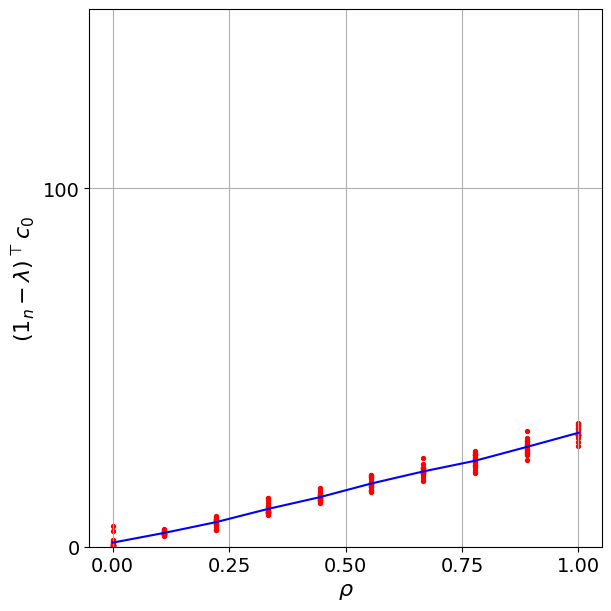

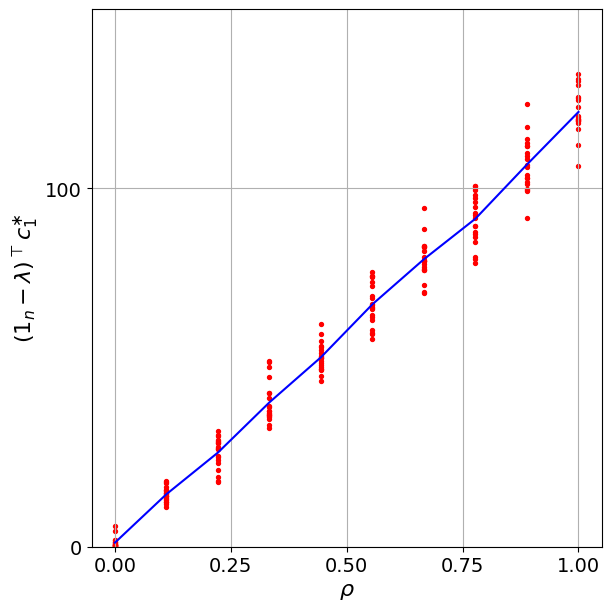

In [29]:
# figures for paper ------------------------------------------------------------------------------------------
plt.figure(figsize=(6, 6), layout='constrained')
for I, s in enumerate(sfvals):
  plt.scatter(s * np.ones((num_e,)), co_nrm[I], s=8, color='r', marker='o', zorder=-1)
plt.plot(sfvals, np.mean(co_nrm, axis=1), color='b')
plt.grid('both')
plt.xlim([ -0.05, 1.05 ])
plt.ylim([ 0, 150 ])
plt.xticks([ 0, 0.25, 0.50, 0.75, 1.00 ], labels=tick_labels, fontsize=14)
plt.yticks([ 0, 100 ], fontsize=14)
plt.xlabel('$\\rho$', fontsize=16)
plt.ylabel('$(1_n - \\lambda)^{\\top} c_0$', fontsize=16)

savefig('NORM_CTRUE', d, num_e)

plt.show()

plt.figure(figsize=(6, 6), layout='constrained')
for I, s in enumerate(sfvals):
  plt.scatter(s * np.ones((num_e,)), c_nrm[I], s=8, color='r', marker='o', zorder=-1)
plt.plot(sfvals, np.mean(c_nrm, axis=1), color='b')
plt.grid('both')
plt.xlim([ -0.05, 1.05 ])
plt.ylim([ 0, 150 ])
plt.xticks([ 0, 0.25, 0.50, 0.75, 1.00 ], labels=tick_labels, fontsize=14)
plt.yticks([ 0, 100 ], fontsize=14)
plt.xlabel('$\\rho$', fontsize=16)
plt.ylabel('$(1_n - \\lambda)^{\\top} c_1^{\\ast}$', fontsize=16)

savefig('NORM_CL1', d, num_e)

plt.show()

For a given parameter $\alpha > 0$, lifted atomic norm recovery solves
$$
  \text{minimize}_{\boldsymbol{c}\in \mathbb{R}^n_+}\quad (\boldsymbol{1}_n - \boldsymbol{\lambda})^{\top}\boldsymbol{c}\quad\text{subject to}\quad \boldsymbol{\Phi}\boldsymbol{A}\boldsymbol{c} = \boldsymbol{y}_0\quad\text{and}\quad \boldsymbol{\lambda}^{\top}\boldsymbol{c} \leq \alpha.
$$
If $\boldsymbol{c}^\star$ is an optimal solution to the above, then $\boldsymbol{x}^{\star} = \bar{\boldsymbol{A}}\boldsymbol{c}^{\star}$ is the recovered signal.

Only the values for $\alpha\in\{50, 100, 150\}$ are precomputed.

In [30]:
from liftedAtomicNormRecovery.solver.cvxpy import LiftedAtomicNormRecoveryLiftCoordinate

atomicRecovery = LiftedAtomicNormRecoveryLiftCoordinate()

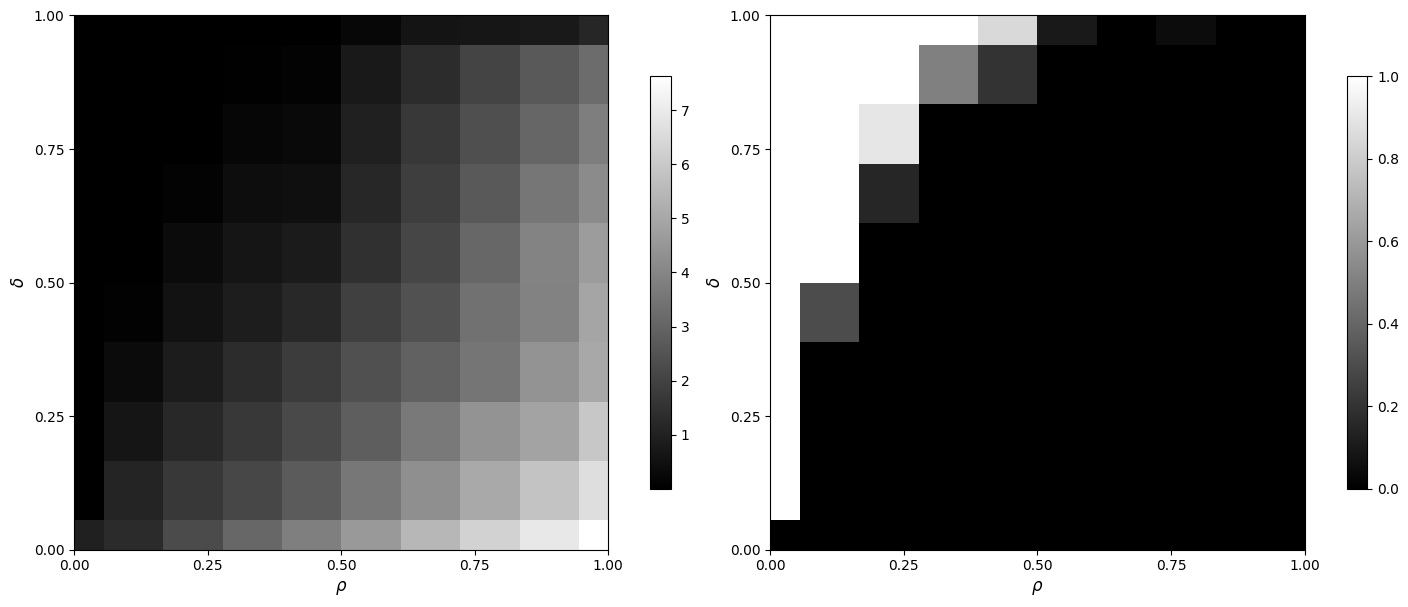

In [ ]:
alpha = 50

fname = f'DAT/E01_LIFTED_ATOMIC_NORM_LIFTED_COORDINATE_A{alpha:04d}_D{d:04d}_NS{num_e:04}.npz'

if LOAD_DATA and exists(fname):
  err = np.load(fname)['err']
  xo_nrm = np.load(fname)['xo_nrm']
else:
  err, xo_nrm, co_nrm, c_nrm = recovery_experiment(draw_signal, lambda T, y : atomicRecovery.solve(A, T, y, lam_A, alpha=alpha))

  if SAVE_DATA:
    np.savez(fname, err=err, xo_nrm=xo_nrm, co_nrm=co_nrm, c_nrm=c_nrm)
    
plot_results(err, xo_nrm)

In [38]:
# figure for paper ------------------------------------------------------------------------------------------

F = np.mean(np.where(err <= 1E-2 * xo_nrm, 1.0, 0.0), axis=2)

plt.figure(figsize=(6, 6), layout='constrained')
plt.imshow(F, origin='lower', vmin=0, vmax=1, cmap='gray')
plt.xlim([ 0, num_s - 1 ])
plt.ylim([ 0, num_m - 1 ])
plt.xticks(ticks, labels=tick_labels, fontsize=14)
plt.yticks(ticks, labels=tick_labels, fontsize=14)
plt.xlabel('$\\rho$', fontsize=16)
plt.ylabel('$\\delta$', fontsize=16)
cb = plt.colorbar(shrink=0.5, ticks=[ 0.0, 0.25, 0.50, 0.75, 1.00 ])
cb.ax.tick_params(labelsize=14)

savefig(f'PD_LIFTED_A{alpha:04d}', d, num_e)

plt.close()